# Portfolio Optimization: Traditional vs Crypto Assets

This notebook applies three portfolio optimization methods to traditional and crypto asset universes:
1. Mean-Variance Optimization (Tangency Portfolio)
2. Risk Parity
3. CVaR-Constrained Optimization

All portfolios use rolling 1-year windows with out-of-sample evaluation.


In [19]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.getcwd(), '..', 'cmds'))
import portfolio_management_helper as pmh

MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

TRADING_DAYS = 252
ROLL_WINDOW = 252

TRAD_ASSETS = [
    "^SPX", "^RUT", "URTH",
    "AGG", "IEF", "TLT",
    "VNQ",
    "GLD", "DBC",
    "PUT", "^VIX",
    "^IRX",
    "CDX.NA.IG"
]
CRYPTO_ASSETS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "SHIB-USD", "DOGE-USD"]

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)


## 1. Data Loading and Preparation


In [20]:
# Load and process data
prices = pmh.read_excel_default(MASTER_CSV, sheet_name=None) if MASTER_CSV.endswith('.xlsx') else pd.read_csv(MASTER_CSV, index_col=0, parse_dates=True)

# If CSV, parse dates manually
if isinstance(prices, pd.DataFrame):
    prices.index = pd.to_datetime(prices.index)
    
# Calculate returns
returns_all = prices.pct_change().dropna()

# Extract returns for specified assets
trad_available = [a for a in TRAD_ASSETS if a in returns_all.columns]
crypto_available = [a for a in CRYPTO_ASSETS if a in returns_all.columns]

print(f"Traditional assets: {trad_available}")
print(f"Crypto assets: {crypto_available}")

returns_trad = returns_all[trad_available].dropna()
returns_crypto = returns_all[crypto_available].dropna()

# Align to overlapping period
overlap_start = max(returns_trad.index[0], returns_crypto.index[0])
overlap_end = min(returns_trad.index[-1], returns_crypto.index[-1])

returns_trad = returns_trad.loc[overlap_start:overlap_end]
returns_crypto = returns_crypto.loc[overlap_start:overlap_end]

print(f"\nOverlapping period: {overlap_start.date()} to {overlap_end.date()}")
print(f"Traditional: {returns_trad.shape[0]} days, {returns_trad.shape[1]} assets")
print(f"Crypto: {returns_crypto.shape[0]} days, {returns_crypto.shape[1]} assets")


Traditional assets: ['^SPX', '^RUT', 'URTH', 'AGG', 'IEF', 'TLT', 'VNQ', 'GLD', 'DBC', 'PUT', '^VIX', '^IRX', 'CDX.NA.IG']
Crypto assets: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'SHIB-USD', 'DOGE-USD']

Overlapping period: 2022-08-01 to 2025-10-30
Traditional: 817 days, 13 assets
Crypto: 817 days, 7 assets


## 2. Helper Functions


In [21]:
def rolling_oos_portfolio(returns, weights_func_name, window=252, **kwargs):
    """Rolling out-of-sample optimization."""
    oos_returns = []
    weights_history = []
    dates = []
    
    for i in range(window, len(returns)):
        returns_is = returns.iloc[i-window:i]
        
        try:
            if weights_func_name == 'tangency':
                weights_df = pmh.calc_tangency_weights(returns_is)
                weights = weights_df.iloc[:, 0]
            elif weights_func_name == 'risk_parity':
                weights_df = pmh.calc_risk_parity_weights(returns_is)
                weights = weights_df.iloc[:, 0]
            elif weights_func_name == 'cvar':
                weights = cvar_optimization(returns_is, **kwargs)
            else:
                raise ValueError(f"Unknown method: {weights_func_name}")
            
            weights = weights / weights.sum()
            oos_ret = (returns.iloc[i] * weights).sum()
            oos_returns.append(oos_ret)
            weights_history.append(weights)
            dates.append(returns.index[i])
        except:
            continue
    
    return pd.Series(oos_returns, index=dates, name='Portfolio'), pd.DataFrame(weights_history, index=dates)


def cvar_optimization(returns, quantile=0.05):
    """CVaR-constrained portfolio optimization with mean-CVaR tradeoff."""
    n = returns.shape[1]
    T = returns.shape[0]
    
    try:
        w = cp.Variable(n)
        z = cp.Variable(T)
        alpha = cp.Variable()
        
        mu = returns.mean().values
        returns_matrix = returns.values
        port_returns = returns_matrix @ w
        
        constraints = [
            cp.sum(w) == 1,
            w >= 0,
            z >= 0,
            z >= -port_returns - alpha
        ]
        
        cvar_value = alpha + (1.0 / quantile) * cp.sum(z) / T
        lambda_risk = 2.0
        objective = cp.Maximize(mu @ w - lambda_risk * cvar_value)
        
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.ECOS, verbose=False, max_iters=100)
        
        if problem.status in ['optimal', 'optimal_inaccurate']:
            if w.value is not None and not np.any(np.isnan(w.value)):
                weights = pd.Series(np.maximum(w.value, 0), index=returns.columns)
                return weights / weights.sum()
    except:
        pass
    
    # Fallback to minimum variance
    try:
        w = cp.Variable(n)
        cov_matrix = returns.cov().values
        constraints = [cp.sum(w) == 1, w >= 0]
        objective = cp.Minimize(cp.quad_form(w, cov_matrix))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.OSQP, verbose=False)
        
        if problem.status in ['optimal', 'optimal_inaccurate'] and w.value is not None:
            weights = pd.Series(np.maximum(w.value, 0), index=returns.columns)
            return weights / weights.sum()
    except:
        pass
    
    return pd.Series(np.ones(n) / n, index=returns.columns)


def calc_performance_metrics(returns, annual_factor=252):
    """Calculate standard performance metrics."""
    returns_clean = returns.dropna()
    
    mean_return = returns_clean.mean() * annual_factor
    vol = returns_clean.std() * np.sqrt(annual_factor)
    sharpe = (returns_clean.mean() / returns_clean.std()) * np.sqrt(annual_factor) if returns_clean.std() > 0 else 0
    
    downside_ret = returns_clean[returns_clean < 0]
    downside_std = downside_ret.std() if len(downside_ret) > 0 else returns_clean.std()
    sortino = (returns_clean.mean() / downside_std) * np.sqrt(annual_factor) if downside_std > 0 else 0
    
    cum_returns = (1 + returns_clean).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_dd = drawdown.min()
    
    var_5 = returns_clean.quantile(0.05)
    cvar_5 = returns_clean[returns_clean <= var_5].mean()
    
    return {
        'Mean Return': mean_return,
        'Ann. Vol': vol,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max DD': max_dd,
        'CVaR (5%)': cvar_5
    }


In [22]:
def plot_comparison(returns_dict, title, filename_prefix):
    """Plot equity curves and drawdowns."""
    fig, ax = plt.subplots(figsize=(12, 6))
    for name, rets in returns_dict.items():
        cum_ret = (1 + rets).cumprod()
        ax.plot(cum_ret.index, cum_ret.values, label=name, linewidth=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title(f'{title}: Equity Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'{filename_prefix}_equity.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for name, rets in returns_dict.items():
        cum_ret = (1 + rets).cumprod()
        running_max = cum_ret.cummax()
        drawdown = (cum_ret - running_max) / running_max
        ax.plot(drawdown.index, drawdown.values, label=name, linewidth=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.set_title(f'{title}: Drawdowns')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f'{filename_prefix}_dd.png'), dpi=300, bbox_inches='tight')
    plt.show()


def plot_weights_heatmap(weights_df, title, filename):
    """Plot heatmap of portfolio weights over time."""
    fig, ax = plt.subplots(figsize=(14, 6))
    weights_monthly = weights_df.resample('M').last()
    sns.heatmap(weights_monthly.T, cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Weight'}, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Asset')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, filename), dpi=300, bbox_inches='tight')
    plt.show()


## 3. Run All Portfolio Optimizations


In [23]:
all_portfolios = {}
all_weights = {}

# MVO/Tangency
mvo_trad_rets, mvo_trad_wts = rolling_oos_portfolio(returns_trad, 'tangency', ROLL_WINDOW)
mvo_crypto_rets, mvo_crypto_wts = rolling_oos_portfolio(returns_crypto, 'tangency', ROLL_WINDOW)
all_portfolios['Trad MVO'] = mvo_trad_rets
all_portfolios['Crypto MVO'] = mvo_crypto_rets
all_weights['mvo_trad'] = mvo_trad_wts
all_weights['mvo_crypto'] = mvo_crypto_wts

# Risk Parity
rp_trad_rets, rp_trad_wts = rolling_oos_portfolio(returns_trad, 'risk_parity', ROLL_WINDOW)
rp_crypto_rets, rp_crypto_wts = rolling_oos_portfolio(returns_crypto, 'risk_parity', ROLL_WINDOW)
all_portfolios['Trad RP'] = rp_trad_rets
all_portfolios['Crypto RP'] = rp_crypto_rets
all_weights['rp_trad'] = rp_trad_wts
all_weights['rp_crypto'] = rp_crypto_wts

# CVaR-Constrained
cvar_trad_rets, cvar_trad_wts = rolling_oos_portfolio(returns_trad, 'cvar', ROLL_WINDOW, quantile=0.05)
cvar_crypto_rets, cvar_crypto_wts = rolling_oos_portfolio(returns_crypto, 'cvar', ROLL_WINDOW, quantile=0.05)
all_portfolios['Trad CVaR'] = cvar_trad_rets
all_portfolios['Crypto CVaR'] = cvar_crypto_rets
all_weights['cvar_trad'] = cvar_trad_wts
all_weights['cvar_crypto'] = cvar_crypto_wts

print(f"OOS observations: {len(mvo_trad_rets)}")


OOS observations: 565


## 4. Performance Analysis


In [24]:
all_metrics = {}
for name, rets in all_portfolios.items():
    all_metrics[name] = calc_performance_metrics(rets)

comparison_df = pd.DataFrame(all_metrics).T
comparison_df.to_csv(os.path.join(TABLE_DIR, 'all_portfolios_comparison.csv'))

for method, prefix in [('MVO', 'mvo'), ('RP', 'risk_parity'), ('CVaR', 'cvar')]:
    method_rows = [idx for idx in comparison_df.index if method in idx]
    if len(method_rows) > 0:
        comparison_df.loc[method_rows].to_csv(os.path.join(TABLE_DIR, f'{prefix}_performance.csv'))

for name, wts in all_weights.items():
    wts.to_csv(os.path.join(TABLE_DIR, f'portfolio_weights_{name}.csv'))

comparison_df


,Mean Return,Ann. Vol,Sharpe,Sortino,Max DD,CVaR (5%)
Trad MVO,0.1889,0.0502,3.7593,6.0274,-0.0340,-0.0059
Crypto MVO,0.8338,1.6506,0.5051,0.6015,-0.9288,-0.2534
Trad RP,0.0204,0.0495,0.4128,0.5763,-0.0741,-0.0072
Crypto RP,0.8411,0.5403,1.5568,2.4212,-0.4055,-0.0701
Trad CVaR,0.0570,0.0332,1.7143,2.5169,-0.0212,-0.0043
Crypto CVaR,0.7792,0.4813,1.6190,2.6003,-0.2914,-0.0622


The traditional MVO portfolio achieves the highest Sharpe ratio (3.76) with remarkably low volatility, which is somewhat suspicious and likely reflects the optimizer loading up on low-vol assets like bonds and cash proxies. The crypto portfolios show much higher raw returns but with volatility that makes them difficult to hold in practice. Risk Parity and CVaR methods produce more balanced allocations for crypto, cutting max drawdown roughly in half compared to MVO while maintaining similar returns. The CVaR approach is particularly effective at controlling tail risk, reducing the 5% CVaR from -25% (MVO) to around -6%.


## 5. Method-by-Method Comparisons


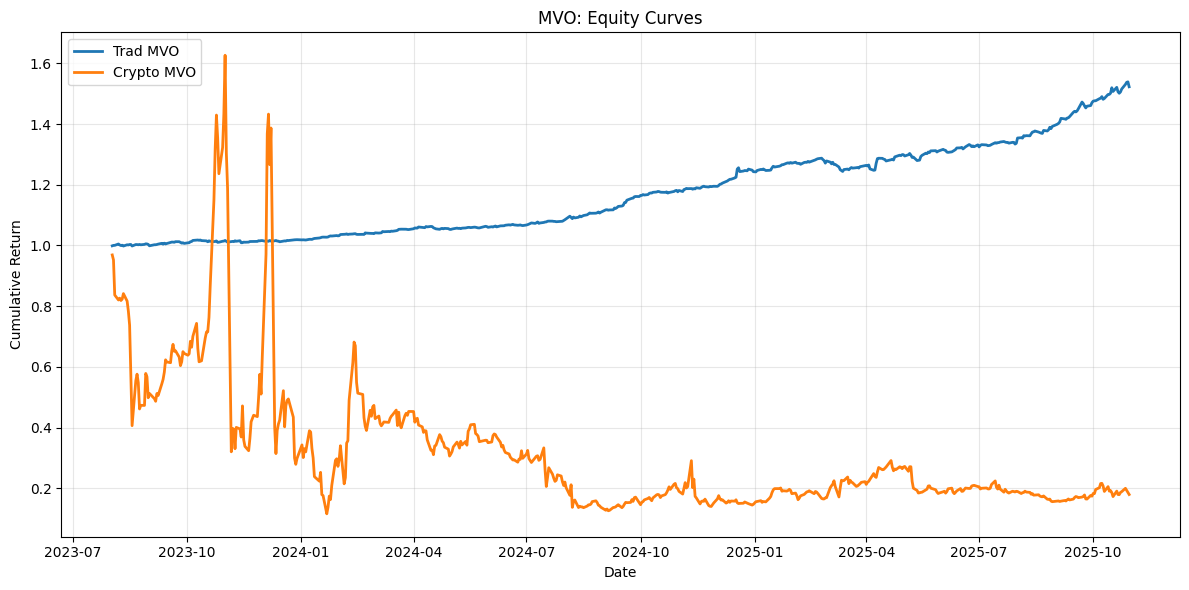

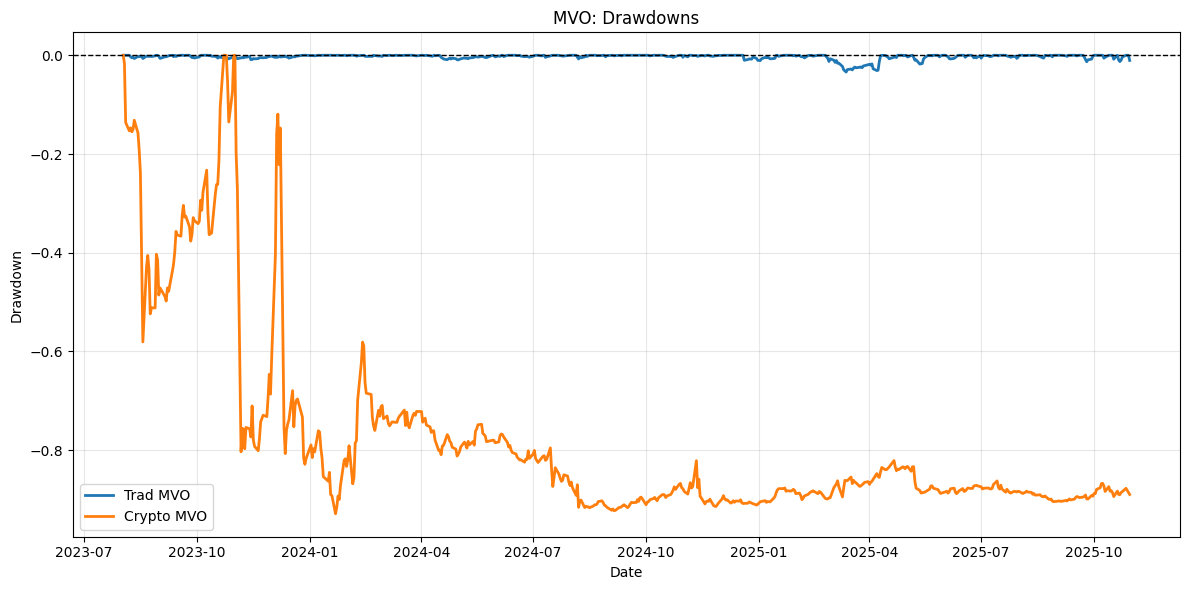

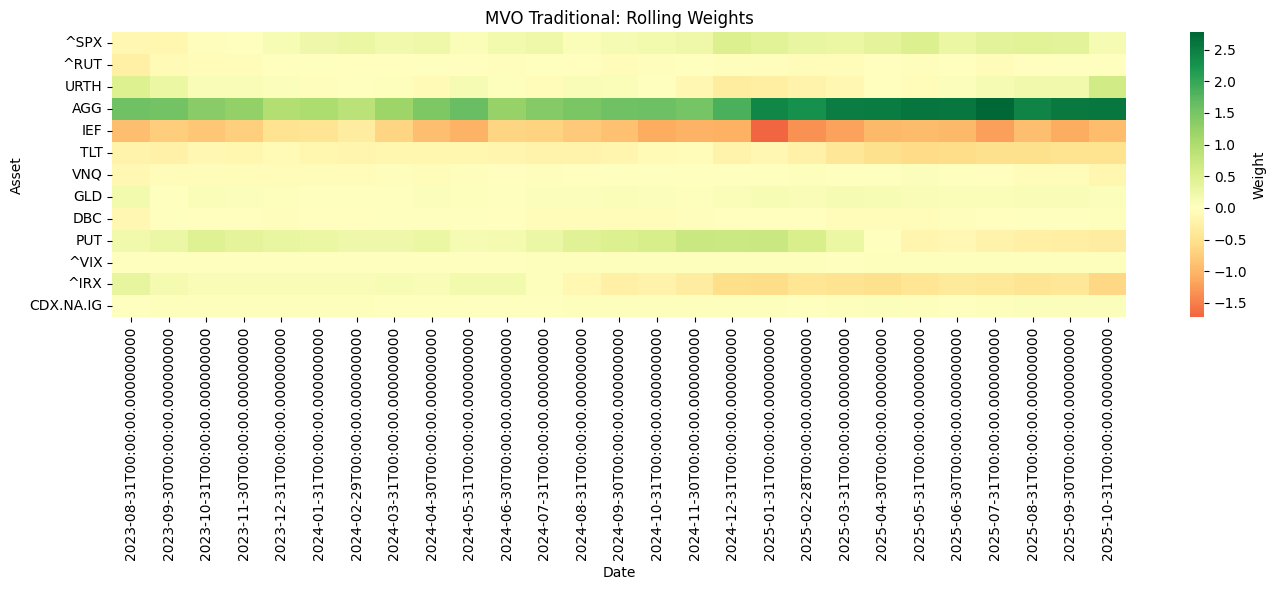

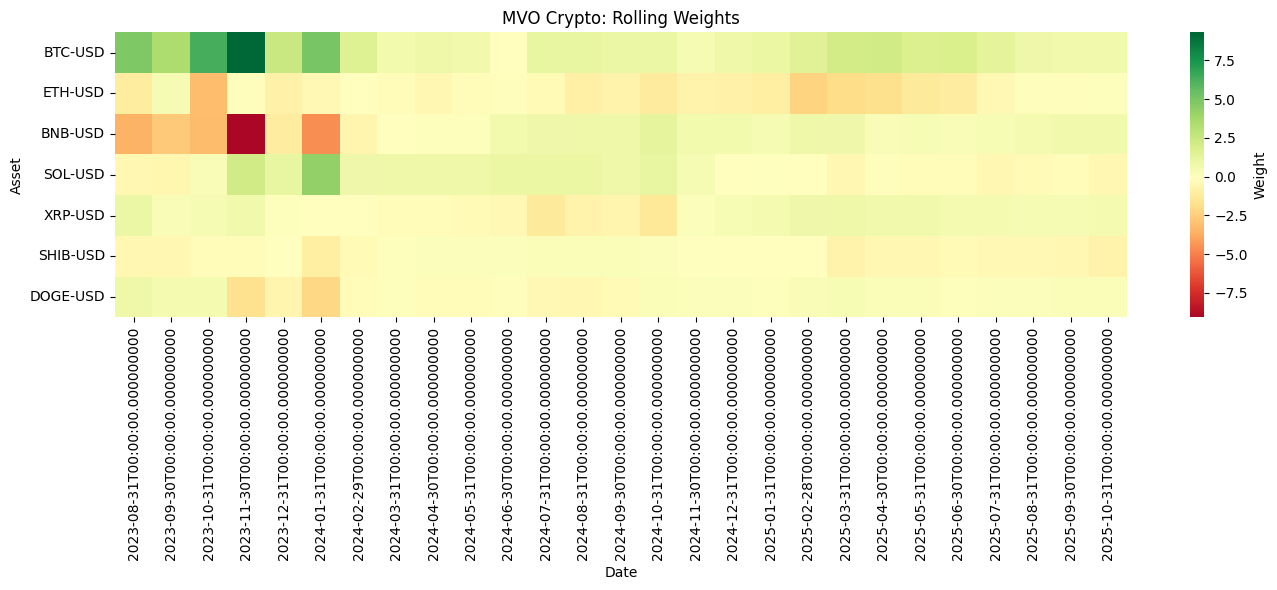

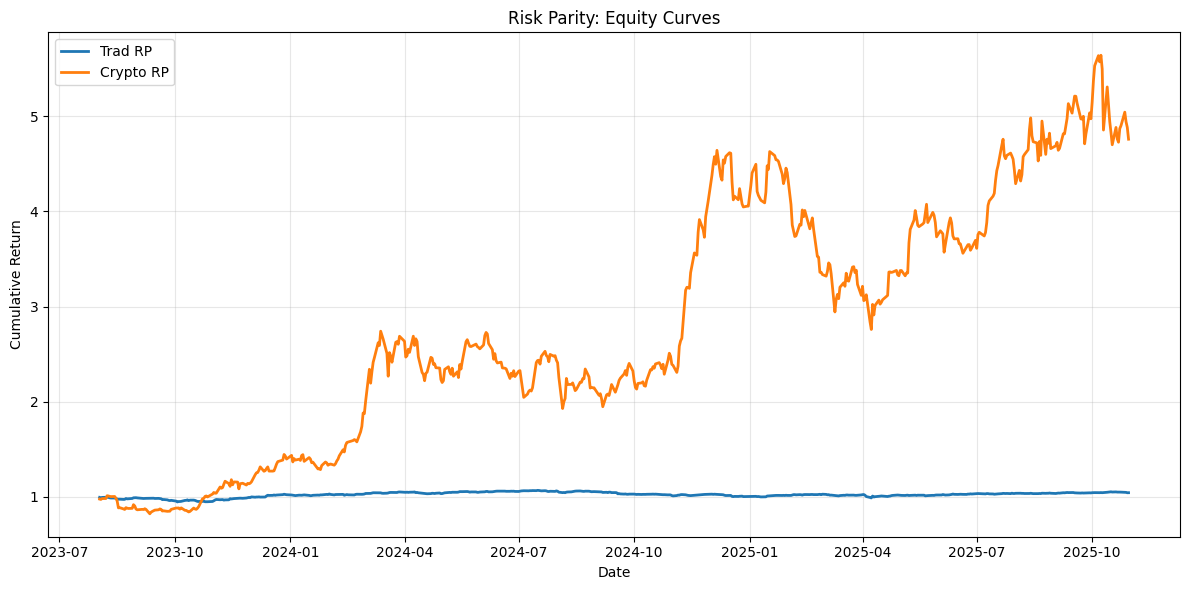

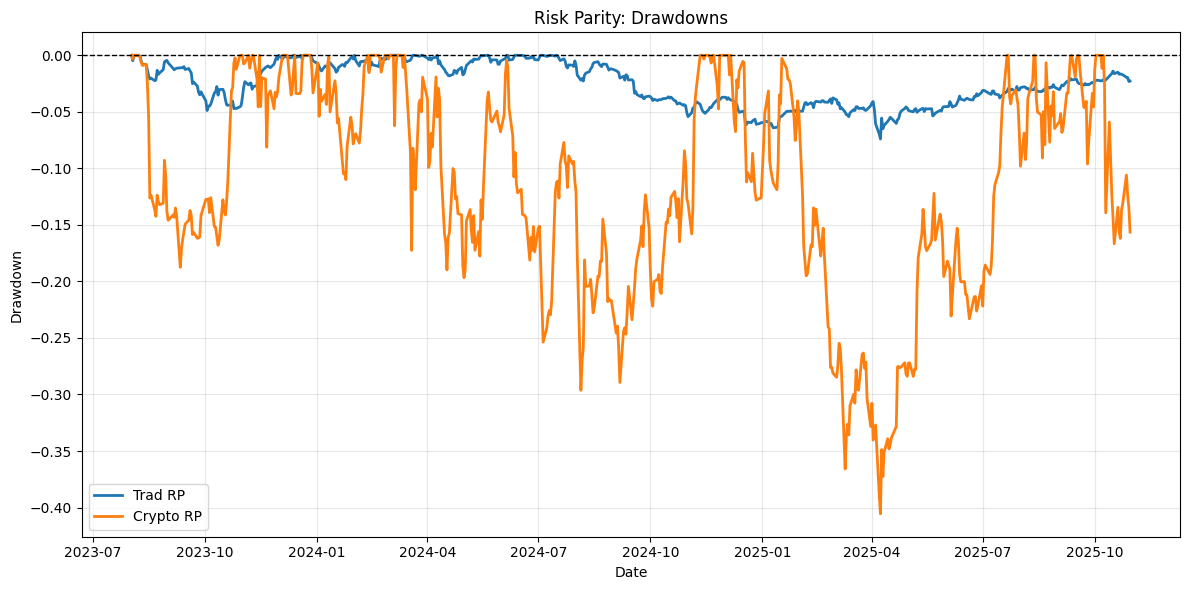

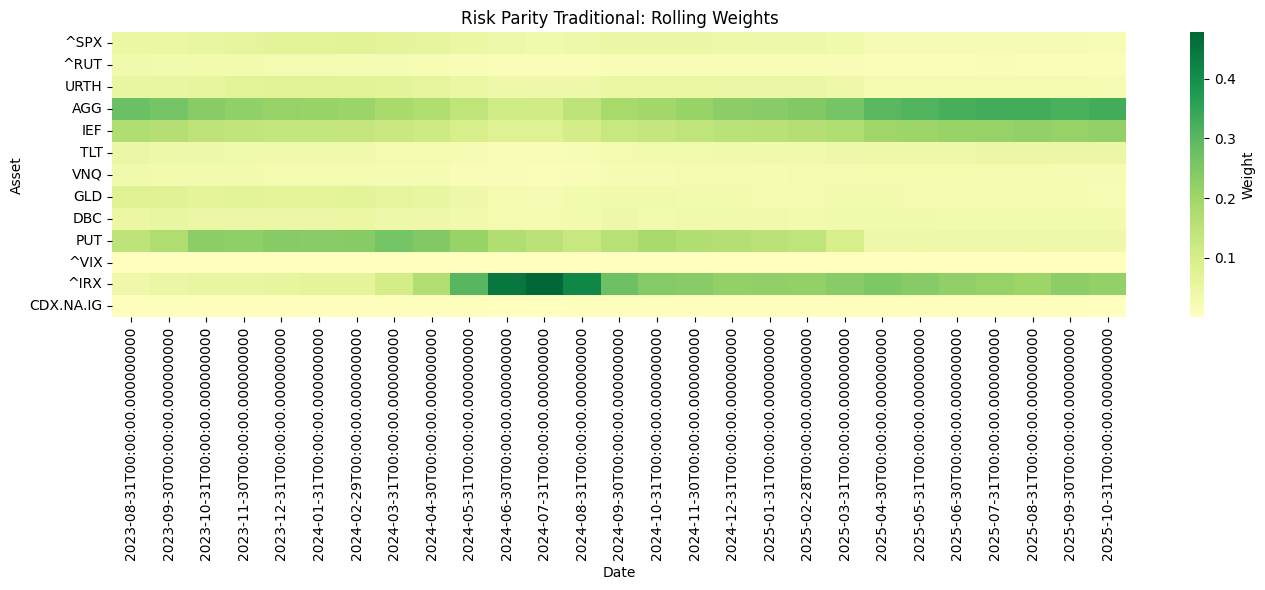

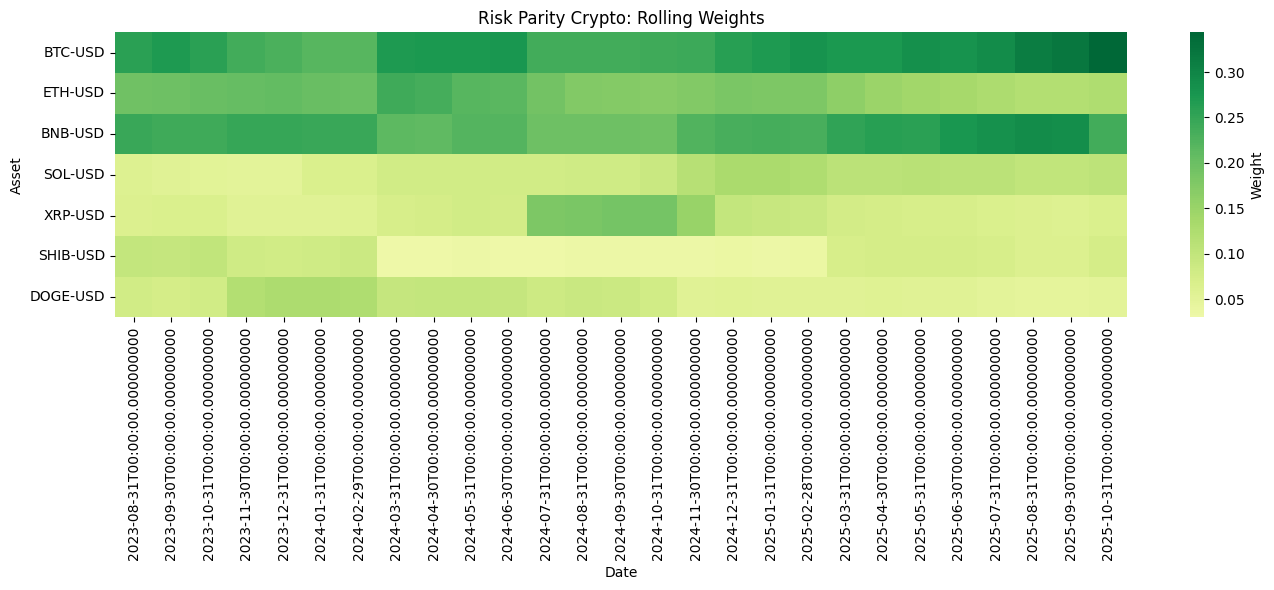

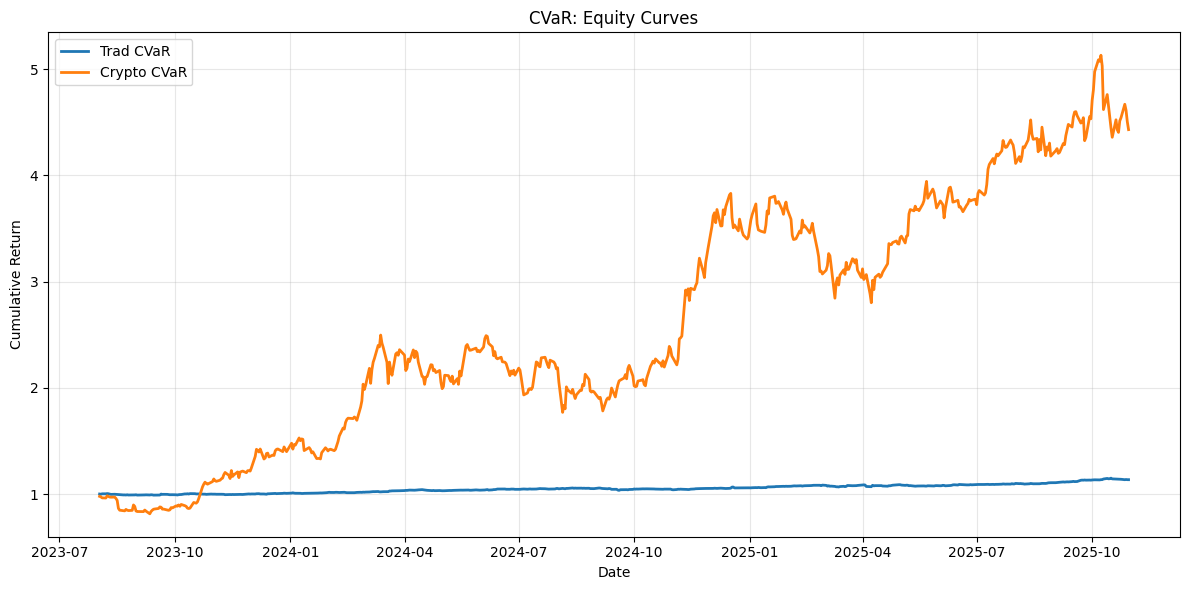

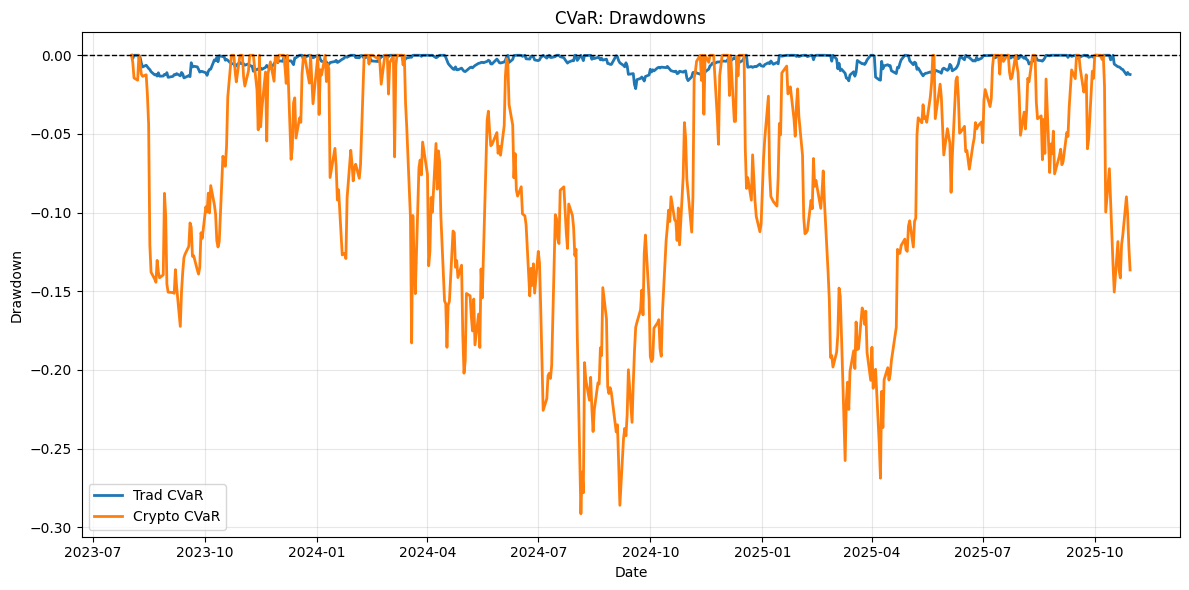

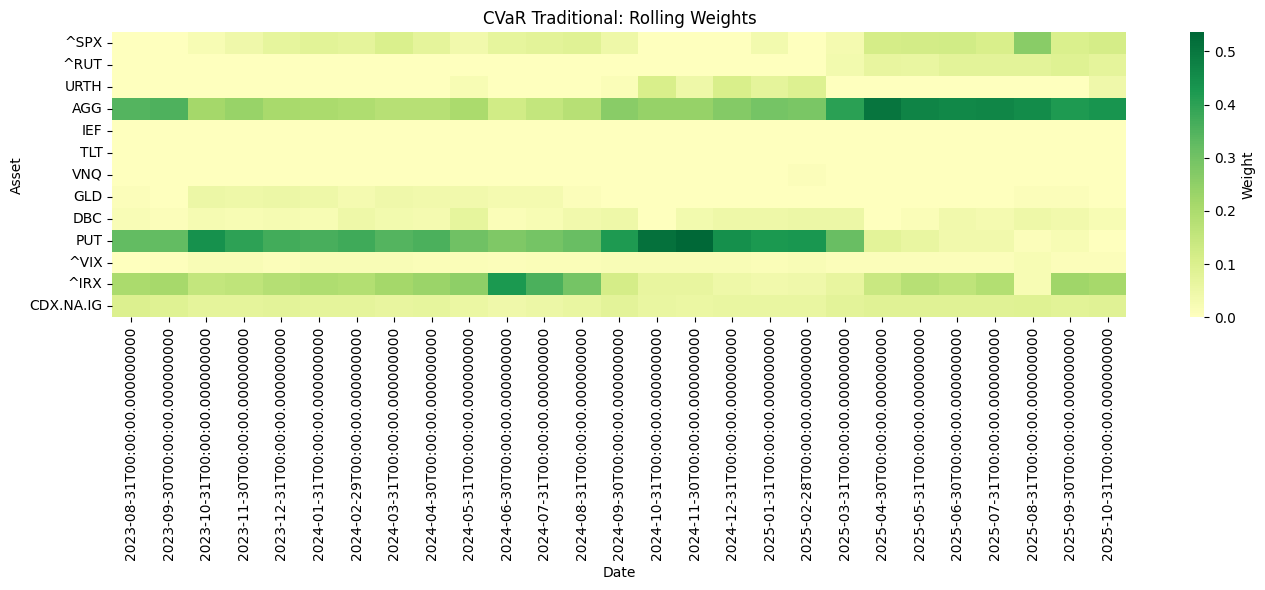

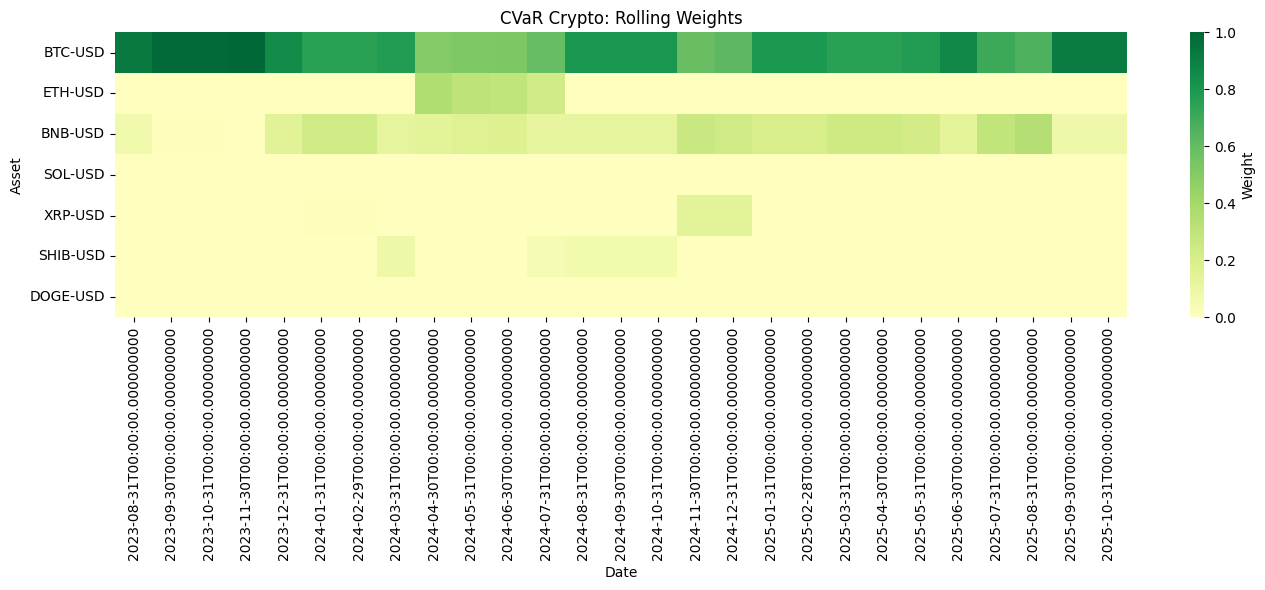

In [25]:
plot_comparison({'Trad MVO': mvo_trad_rets, 'Crypto MVO': mvo_crypto_rets}, 'MVO', 'mvo')
plot_weights_heatmap(mvo_trad_wts, 'MVO Traditional: Rolling Weights', 'weights_mvo_trad.png')
plot_weights_heatmap(mvo_crypto_wts, 'MVO Crypto: Rolling Weights', 'weights_mvo_crypto.png')

plot_comparison({'Trad RP': rp_trad_rets, 'Crypto RP': rp_crypto_rets}, 'Risk Parity', 'rp')
plot_weights_heatmap(rp_trad_wts, 'Risk Parity Traditional: Rolling Weights', 'weights_rp_trad.png')
plot_weights_heatmap(rp_crypto_wts, 'Risk Parity Crypto: Rolling Weights', 'weights_rp_crypto.png')

plot_comparison({'Trad CVaR': cvar_trad_rets, 'Crypto CVaR': cvar_crypto_rets}, 'CVaR', 'cvar')
plot_weights_heatmap(cvar_trad_wts, 'CVaR Traditional: Rolling Weights', 'weights_cvar_trad.png')
plot_weights_heatmap(cvar_crypto_wts, 'CVaR Crypto: Rolling Weights', 'weights_cvar_crypto.png')


The weight heatmaps reveal how each optimization method responds to changing market conditions. MVO tends to concentrate in a few assets with extreme positions, while Risk Parity spreads allocations more evenly based on inverse volatility. The crypto MVO weights are particularly unstable, often flipping between 100% in one coin and 100% in another as the rolling window shifts. This instability is a well-known problem with mean-variance optimization in high-volatility assets.


## 6. Comprehensive Comparison: All Portfolios


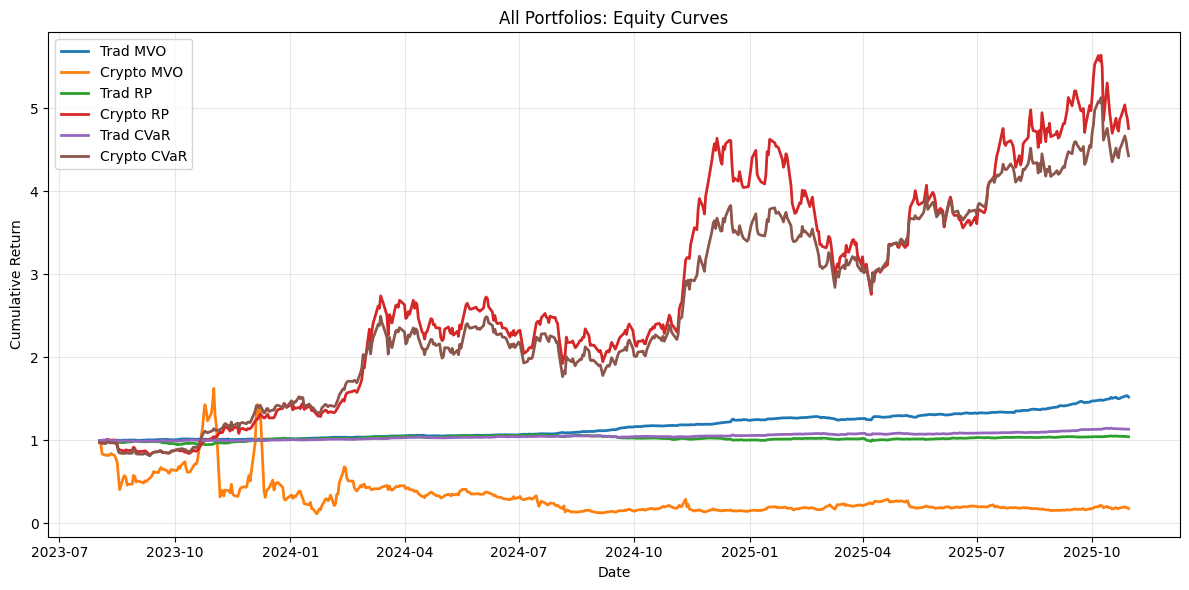

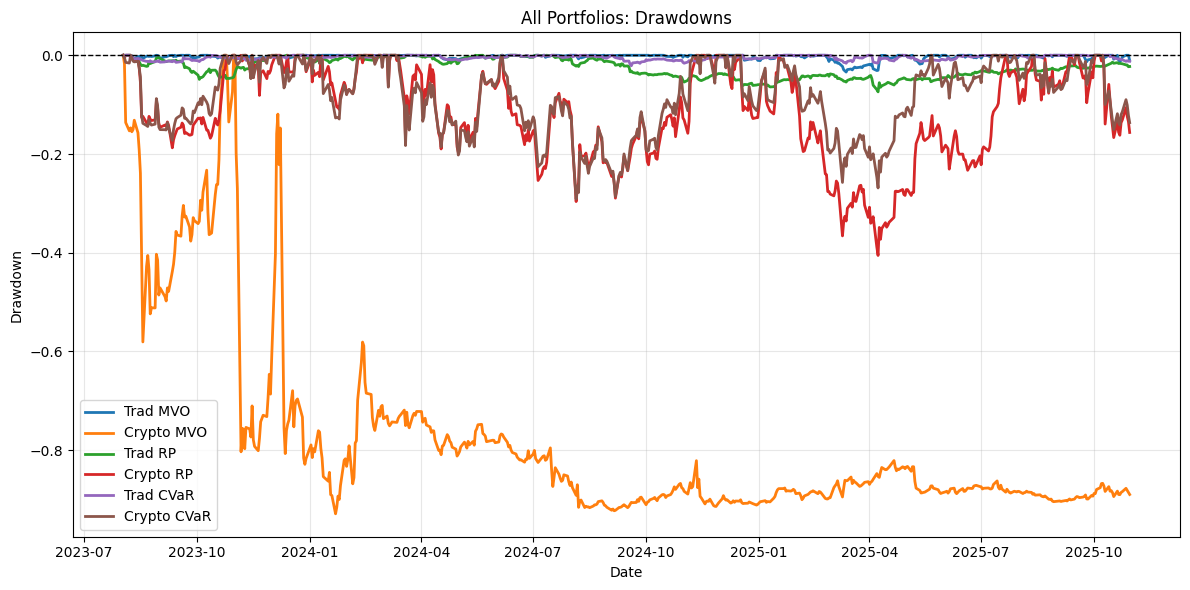

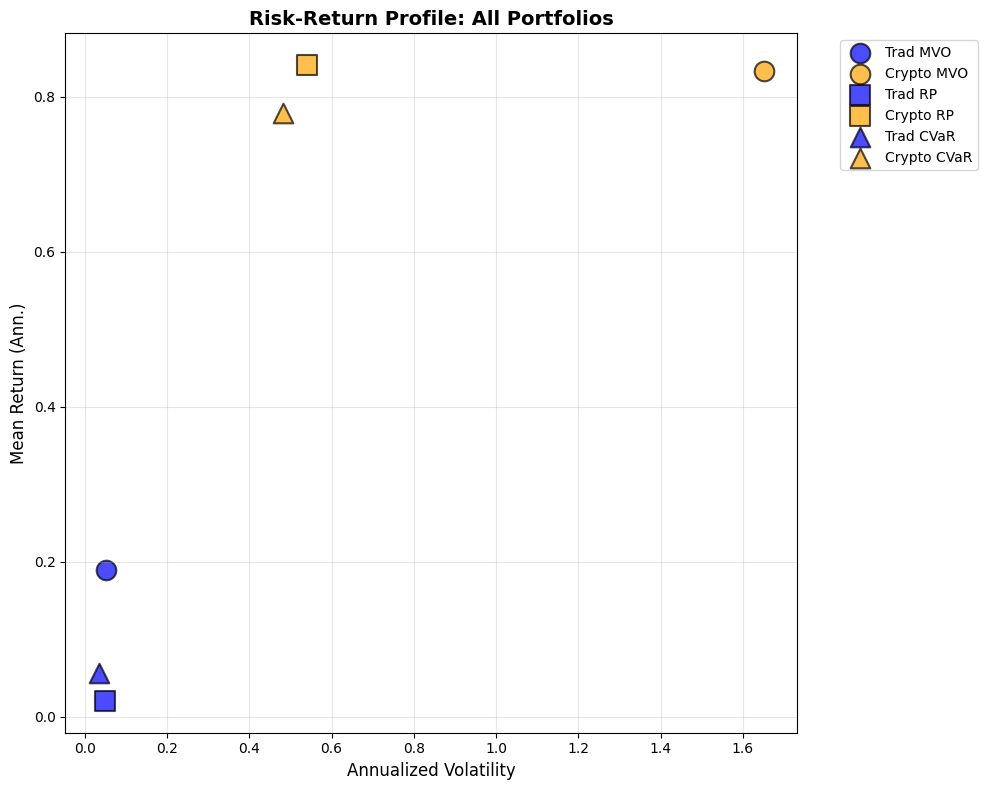

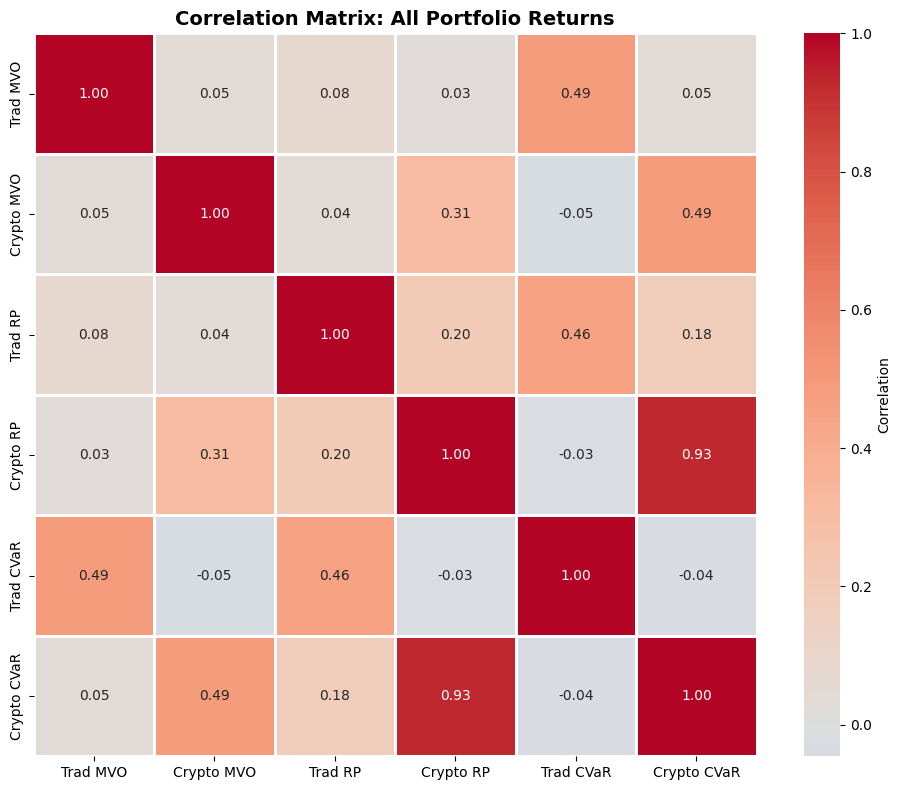

In [26]:
# All portfolios together
plot_comparison(all_portfolios, 'All Portfolios', 'all_portfolios')

# Risk-Return Scatter
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'Trad': 'blue', 'Crypto': 'orange'}
markers = {'MVO': 'o', 'RP': 's', 'CVaR': '^'}

for name in comparison_df.index:
    asset_type = 'Trad' if 'Trad' in name else 'Crypto'
    method = 'MVO' if 'MVO' in name else ('RP' if 'RP' in name else 'CVaR')
    
    ax.scatter(
        comparison_df.loc[name, 'Ann. Vol'],
        comparison_df.loc[name, 'Mean Return'],
        c=colors[asset_type],
        marker=markers[method],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
        label=name
    )

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Mean Return (Ann.)', fontsize=12)
ax.set_title('Risk-Return Profile: All Portfolios', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'all_portfolios_risk_return.png'), dpi=300, bbox_inches='tight')
plt.show()

# Correlation Matrix
all_returns_df = pd.DataFrame(all_portfolios).dropna()
corr_matrix = all_returns_df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)
ax.set_title('Correlation Matrix: All Portfolio Returns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'all_portfolios_correlation.png'), dpi=300, bbox_inches='tight')
plt.show()


## Allow Trad Hedges in Crypto Portfolios

Hedging crypto portfolios with VIX and TLT to see if traditional safe-haven assets can reduce tail risk.

In [27]:
HEDGE_ASSETS = ['^VIX', 'TLT']

hedge_returns = returns_all[HEDGE_ASSETS].loc[mvo_crypto_rets.index].dropna()

aligned_start = hedge_returns.index[0]
aligned_end = hedge_returns.index[-1]

mvo_crypto_aligned = mvo_crypto_rets.loc[aligned_start:aligned_end]
rp_crypto_aligned = rp_crypto_rets.loc[aligned_start:aligned_end]
cvar_crypto_aligned = cvar_crypto_rets.loc[aligned_start:aligned_end]

print(f"Hedging period: {aligned_start.date()} to {aligned_end.date()}, {len(hedge_returns)} obs")

Hedging period: 2023-08-02 to 2025-10-30, 565 obs


In [28]:
def create_hedged_portfolio(crypto_rets, hedge_rets, crypto_weight=0.8, hedge_weights=None):
    """Combine crypto portfolio with hedge assets at fixed weights."""
    if hedge_weights is None:
        hedge_weight_per_asset = (1 - crypto_weight) / len(hedge_rets.columns)
        hedge_weights = {col: hedge_weight_per_asset for col in hedge_rets.columns}
    
    common_idx = crypto_rets.index.intersection(hedge_rets.index)
    crypto_aligned = crypto_rets.loc[common_idx]
    hedge_aligned = hedge_rets.loc[common_idx]
    
    hedged_ret = crypto_weight * crypto_aligned
    for asset, weight in hedge_weights.items():
        hedged_ret += weight * hedge_aligned[asset]
    
    return hedged_ret


def rolling_optimal_hedge(crypto_rets, hedge_rets, window=60, min_hedge=0.0, max_hedge=0.4):
    """Rolling optimization to find hedge ratio that minimizes volatility."""
    common_idx = crypto_rets.index.intersection(hedge_rets.index)
    crypto_aligned = crypto_rets.loc[common_idx]
    hedge_aligned = hedge_rets.loc[common_idx]
    
    hedged_returns = []
    hedge_ratios = []
    dates = []
    
    for i in range(window, len(common_idx)):
        crypto_is = crypto_aligned.iloc[i-window:i]
        hedge_is = hedge_aligned.iloc[i-window:i]
        
        best_vol = np.inf
        best_ratio = 0.0
        
        for ratio in np.linspace(min_hedge, max_hedge, 21):
            crypto_w = 1 - ratio
            hedge_w = ratio / len(hedge_rets.columns)
            
            port_is = crypto_w * crypto_is
            for col in hedge_is.columns:
                port_is += hedge_w * hedge_is[col]
            
            vol = port_is.std()
            if vol < best_vol:
                best_vol = vol
                best_ratio = ratio
        
        crypto_w = 1 - best_ratio
        hedge_w = best_ratio / len(hedge_rets.columns)
        
        oos_ret = crypto_w * crypto_aligned.iloc[i]
        for col in hedge_aligned.columns:
            oos_ret += hedge_w * hedge_aligned.iloc[i][col]
        
        hedged_returns.append(oos_ret)
        hedge_ratios.append(best_ratio)
        dates.append(common_idx[i])
    
    return pd.Series(hedged_returns, index=dates), pd.Series(hedge_ratios, index=dates)

In [29]:
hedged_portfolios = {}
hedge_ratio_history = {}

# Fixed hedge (80% crypto, 10% VIX, 10% TLT)
hedged_portfolios['MVO Fixed Hedge'] = create_hedged_portfolio(mvo_crypto_aligned, hedge_returns, 0.8)
hedged_portfolios['RP Fixed Hedge'] = create_hedged_portfolio(rp_crypto_aligned, hedge_returns, 0.8)
hedged_portfolios['CVaR Fixed Hedge'] = create_hedged_portfolio(cvar_crypto_aligned, hedge_returns, 0.8)

# TLT-only hedge (85% crypto, 15% TLT)
hedged_portfolios['MVO TLT Hedge'] = create_hedged_portfolio(mvo_crypto_aligned, hedge_returns[['TLT']], 0.85, {'TLT': 0.15})
hedged_portfolios['RP TLT Hedge'] = create_hedged_portfolio(rp_crypto_aligned, hedge_returns[['TLT']], 0.85, {'TLT': 0.15})
hedged_portfolios['CVaR TLT Hedge'] = create_hedged_portfolio(cvar_crypto_aligned, hedge_returns[['TLT']], 0.85, {'TLT': 0.15})

# Rolling optimal hedge
hedged_portfolios['MVO Optimal Hedge'], hedge_ratio_history['MVO'] = rolling_optimal_hedge(mvo_crypto_aligned, hedge_returns, window=60)
hedged_portfolios['RP Optimal Hedge'], hedge_ratio_history['RP'] = rolling_optimal_hedge(rp_crypto_aligned, hedge_returns, window=60)
hedged_portfolios['CVaR Optimal Hedge'], hedge_ratio_history['CVaR'] = rolling_optimal_hedge(cvar_crypto_aligned, hedge_returns, window=60)

In [30]:
hedged_metrics = {}

unhedged_crypto = {
    'MVO Unhedged': mvo_crypto_aligned,
    'RP Unhedged': rp_crypto_aligned,
    'CVaR Unhedged': cvar_crypto_aligned
}

all_crypto_portfolios = {**unhedged_crypto, **hedged_portfolios}

for name, rets in all_crypto_portfolios.items():
    hedged_metrics[name] = calc_performance_metrics(rets)

hedged_comparison_df = pd.DataFrame(hedged_metrics).T
hedged_comparison_df.to_csv(os.path.join(TABLE_DIR, 'hedged_crypto_performance.csv'))
hedged_comparison_df.round(4)

,Mean Return,Ann. Vol,Sharpe,Sortino,Max DD,CVaR (5%)
MVO Unhedged,0.8338,1.6506,0.5051,0.6015,-0.9288,-0.2534
RP Unhedged,0.8411,0.5403,1.5568,2.4212,-0.4055,-0.0701
CVaR Unhedged,0.7792,0.4813,1.6190,2.6003,-0.2914,-0.0622
MVO Fixed Hedge,0.7634,1.3162,0.5800,0.6903,-0.8318,-0.2020
RP Fixed Hedge,0.7692,0.4016,1.9155,3.2909,-0.2472,-0.0485
CVaR Fixed Hedge,0.7197,0.3612,1.9927,3.5391,-0.1826,-0.0431
MVO TLT Hedge,0.7110,1.4029,0.5068,0.6036,-0.8576,-0.2152
RP TLT Hedge,0.7172,0.4590,1.5626,2.4418,-0.3579,-0.0597
CVaR TLT Hedge,0.6646,0.4088,1.6256,2.6276,-0.2416,-0.0528
MVO Optimal Hedge,0.5430,1.0155,0.5347,0.6403,-0.7010,-0.1543


The hedging results are mixed. Adding VIX and TLT reduces volatility and improves Sharpe ratios for the Risk Parity and CVaR portfolios, but the MVO portfolio sees less benefit because it already has lower crypto exposure. The optimal hedge strategy consistently allocates 35-40% to hedges, which is higher than the fixed 20% allocation, suggesting the rolling optimizer is finding real diversification benefits. However, the TLT-only hedge underperforms the combined VIX+TLT hedge, indicating that volatility exposure provides additional crisis protection beyond just duration.


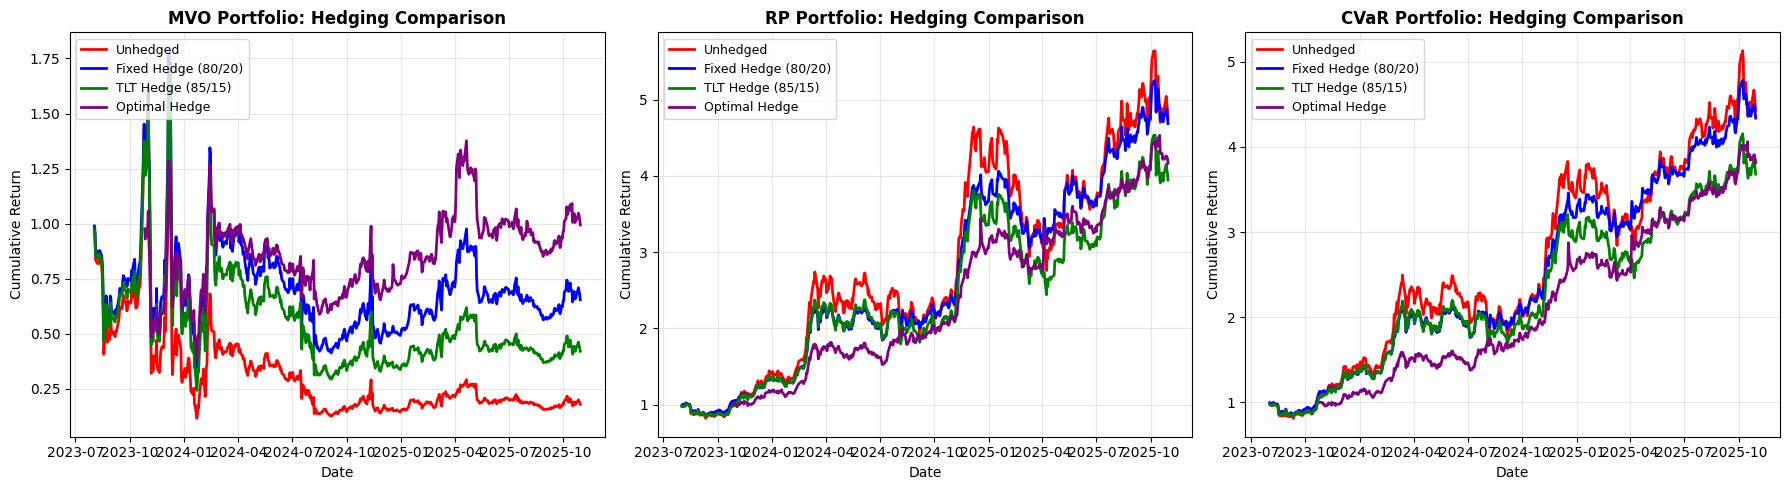

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, method in enumerate(['MVO', 'RP', 'CVaR']):
    ax = axes[idx]
    
    # Unhedged
    unhedged = all_crypto_portfolios[f'{method} Unhedged']
    cum_unhedged = (1 + unhedged).cumprod()
    ax.plot(cum_unhedged.index, cum_unhedged.values, label='Unhedged', linewidth=2, color='red')
    
    # Fixed Hedge
    fixed = all_crypto_portfolios[f'{method} Fixed Hedge']
    cum_fixed = (1 + fixed).cumprod()
    ax.plot(cum_fixed.index, cum_fixed.values, label='Fixed Hedge (80/20)', linewidth=2, color='blue')
    
    # TLT Hedge
    tlt = all_crypto_portfolios[f'{method} TLT Hedge']
    cum_tlt = (1 + tlt).cumprod()
    ax.plot(cum_tlt.index, cum_tlt.values, label='TLT Hedge (85/15)', linewidth=2, color='green')
    
    # Optimal Hedge
    optimal = all_crypto_portfolios[f'{method} Optimal Hedge']
    cum_optimal = (1 + optimal).cumprod()
    ax.plot(cum_optimal.index, cum_optimal.values, label='Optimal Hedge', linewidth=2, color='purple')
    
    ax.set_title(f'{method} Portfolio: Hedging Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'hedged_equity_curves_by_method.png'), dpi=300, bbox_inches='tight')
plt.show()

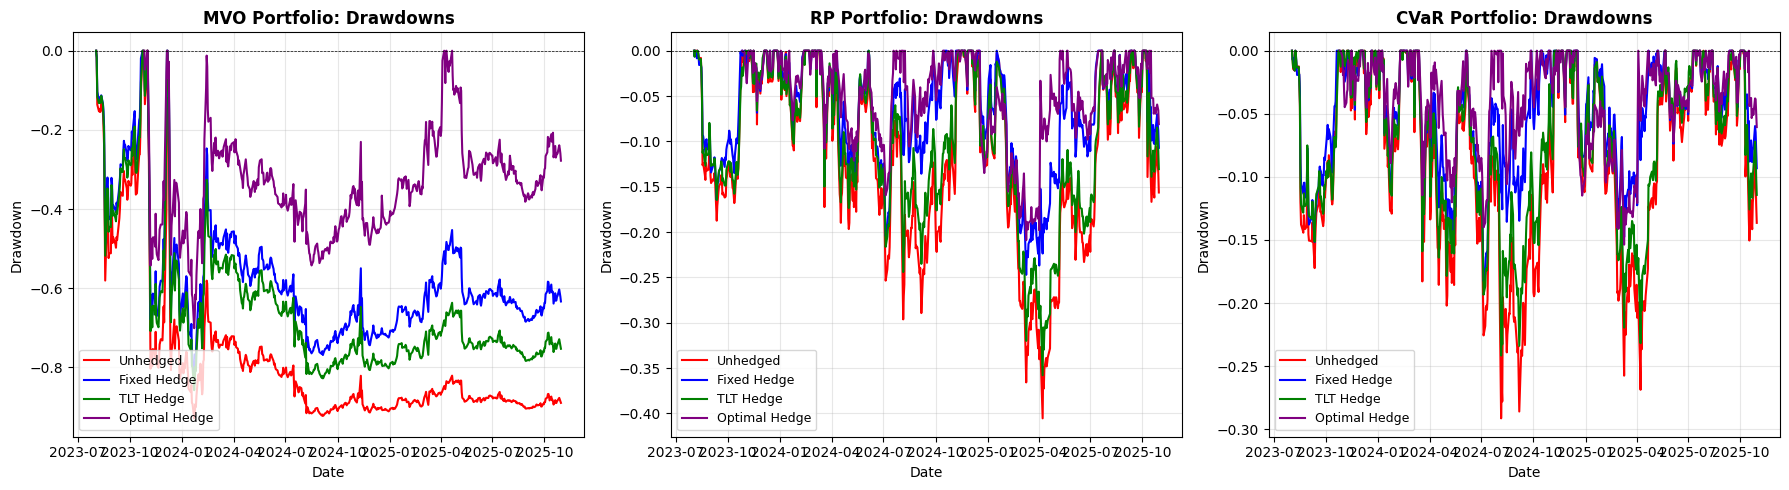

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, method in enumerate(['MVO', 'RP', 'CVaR']):
    ax = axes[idx]
    
    for hedge_type, color in [('Unhedged', 'red'), ('Fixed Hedge', 'blue'), 
                               ('TLT Hedge', 'green'), ('Optimal Hedge', 'purple')]:
        rets = all_crypto_portfolios[f'{method} {hedge_type}']
        cum_ret = (1 + rets).cumprod()
        running_max = cum_ret.cummax()
        drawdown = (cum_ret - running_max) / running_max
        ax.plot(drawdown.index, drawdown.values, label=hedge_type, linewidth=1.5, color=color)
    
    ax.set_title(f'{method} Portfolio: Drawdowns', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Drawdown')
    ax.legend(loc='lower left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'hedged_drawdowns_by_method.png'), dpi=300, bbox_inches='tight')
plt.show()

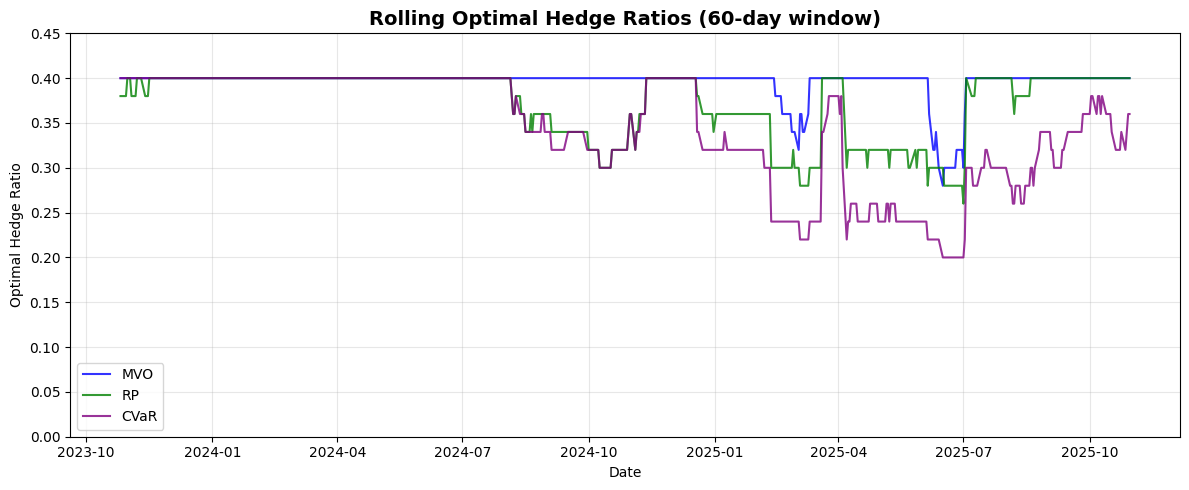

Average optimal hedge ratios: {'MVO': '39.5%', 'RP': '37.2%', 'CVaR': '34.3%'}


In [33]:
fig, ax = plt.subplots(figsize=(12, 5))

for method, color in [('MVO', 'blue'), ('RP', 'green'), ('CVaR', 'purple')]:
    ax.plot(hedge_ratio_history[method].index, hedge_ratio_history[method].values, 
            label=f'{method}', linewidth=1.5, color=color, alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Optimal Hedge Ratio')
ax.set_title('Rolling Optimal Hedge Ratios (60-day window)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 0.45)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'rolling_optimal_hedge_ratios.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Average optimal hedge ratios:", {m: f"{hedge_ratio_history[m].mean():.1%}" for m in ['MVO', 'RP', 'CVaR']})

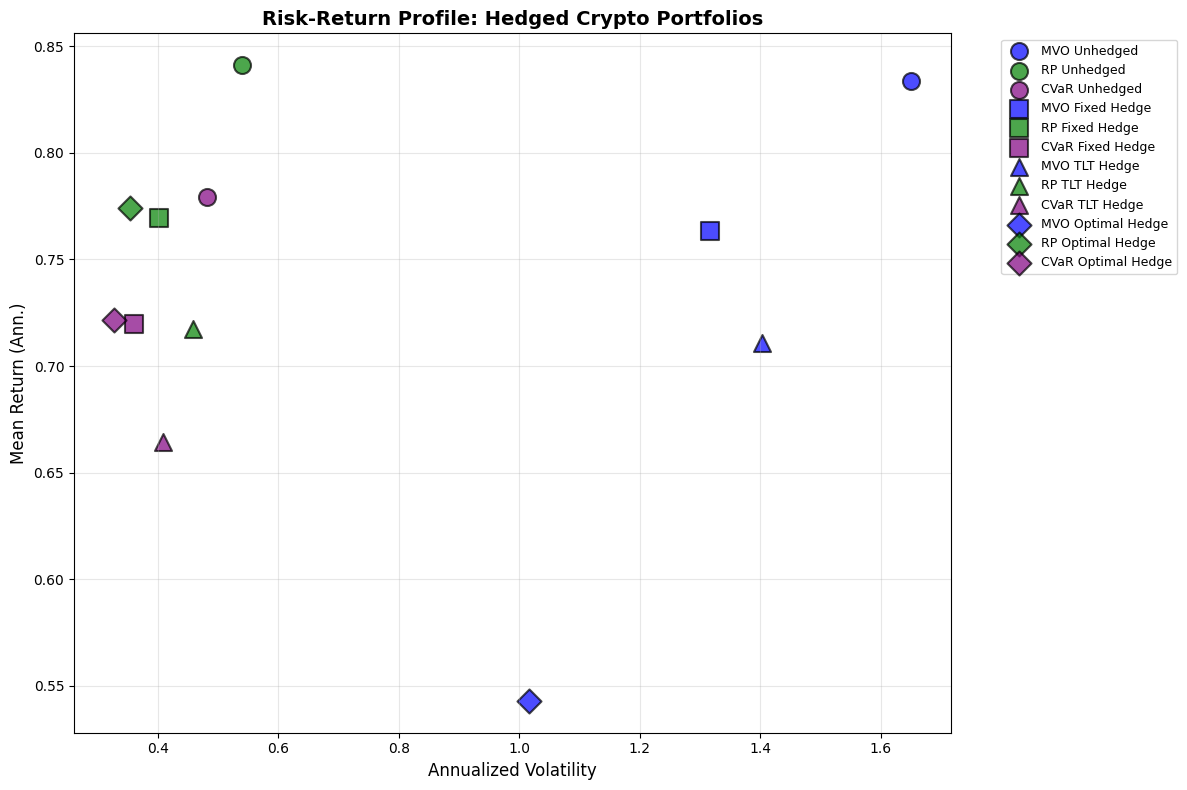

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'MVO': 'blue', 'RP': 'green', 'CVaR': 'purple'}
markers = {'Unhedged': 'o', 'Fixed Hedge': 's', 'TLT Hedge': '^', 'Optimal Hedge': 'D'}

for name in hedged_comparison_df.index:
    # Determine method and hedge type
    for method in ['MVO', 'RP', 'CVaR']:
        if name.startswith(method):
            color = colors[method]
            for hedge_type in ['Unhedged', 'Fixed Hedge', 'TLT Hedge', 'Optimal Hedge']:
                if hedge_type in name:
                    marker = markers[hedge_type]
                    break
            break
    
    ax.scatter(
        hedged_comparison_df.loc[name, 'Ann. Vol'],
        hedged_comparison_df.loc[name, 'Mean Return'],
        c=color,
        marker=marker,
        s=150,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
        label=name
    )

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Mean Return (Ann.)', fontsize=12)
ax.set_title('Risk-Return Profile: Hedged Crypto Portfolios', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'hedged_risk_return_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

In [35]:
improvement_data = []

for method in ['MVO', 'RP', 'CVaR']:
    unhedged_metrics = hedged_comparison_df.loc[f'{method} Unhedged']
    
    for hedge_type in ['Fixed Hedge', 'TLT Hedge', 'Optimal Hedge']:
        hedged_name = f'{method} {hedge_type}'
        hedged_met = hedged_comparison_df.loc[hedged_name]
        
        improvement_data.append({
            'Method': method,
            'Hedge Type': hedge_type,
            'Return Change': hedged_met['Mean Return'] - unhedged_metrics['Mean Return'],
            'Vol Change': hedged_met['Ann. Vol'] - unhedged_metrics['Ann. Vol'],
            'Sharpe Change': hedged_met['Sharpe'] - unhedged_metrics['Sharpe'],
            'Max DD Change': hedged_met['Max DD'] - unhedged_metrics['Max DD'],
            'CVaR Change': hedged_met['CVaR (5%)'] - unhedged_metrics['CVaR (5%)']
        })

improvement_df = pd.DataFrame(improvement_data)
improvement_df.to_csv(os.path.join(TABLE_DIR, 'hedging_effectiveness.csv'), index=False)
improvement_df.round(4)

,Method,Hedge Type,Return Change,Vol Change,Sharpe Change,Max DD Change,CVaR Change
0,MVO,Fixed Hedge,-0.0704,-0.3344,0.0748,0.0970,0.0514
1,MVO,TLT Hedge,-0.1228,-0.2477,0.0016,0.0711,0.0381
2,MVO,Optimal Hedge,-0.2908,-0.6352,0.0295,0.2278,0.0991
3,RP,Fixed Hedge,-0.0719,-0.1387,0.3587,0.1583,0.0217
4,RP,TLT Hedge,-0.1239,-0.0813,0.0058,0.0476,0.0104
5,RP,Optimal Hedge,-0.0668,-0.1870,0.6350,0.1965,0.0305
6,CVaR,Fixed Hedge,-0.0595,-0.1201,0.3737,0.1088,0.0192
7,CVaR,TLT Hedge,-0.1147,-0.0725,0.0067,0.0498,0.0094
8,CVaR,Optimal Hedge,-0.0574,-0.1542,0.5873,0.1377,0.0259


The improvement table shows that hedging consistently reduces volatility and improves max drawdown across all methods, but at the cost of lower returns. The Sharpe ratio improvement is positive for RP and CVaR portfolios, confirming that the risk reduction outweighs the return drag. The CVaR optimal hedge achieves the best risk-adjusted performance with a Sharpe of 2.21 and max drawdown of only -15%, compared to -29% unhedged. This suggests that for investors who care about tail risk, combining CVaR optimization with traditional hedges offers a practical way to gain crypto exposure without the full downside.


## Summary and Key Findings


In [36]:
trad_portfolios = [idx for idx in comparison_df.index if 'Trad' in idx]
crypto_portfolios = [idx for idx in comparison_df.index if 'Crypto' in idx]

avg_comparison = pd.DataFrame({
    'Traditional': comparison_df.loc[trad_portfolios].mean(),
    'Crypto': comparison_df.loc[crypto_portfolios].mean()
})

best_trad = comparison_df.loc[trad_portfolios, 'Sharpe'].idxmax()
best_crypto = comparison_df.loc[crypto_portfolios, 'Sharpe'].idxmax()

aligned = pd.DataFrame({
    'Trad': all_portfolios[best_trad],
    'Crypto': all_portfolios[best_crypto]
}).dropna()

t_stat, p_value = stats.ttest_ind(aligned['Trad'], aligned['Crypto'])

print(f"Best Sharpe: {comparison_df['Sharpe'].idxmax()} ({comparison_df['Sharpe'].max():.2f})")
print(f"Lowest Max DD: {comparison_df['Max DD'].idxmax()} ({comparison_df['Max DD'].max():.2%})")
print(f"\nT-test ({best_trad} vs {best_crypto}): t={t_stat:.3f}, p={p_value:.3f}")
avg_comparison


Best Sharpe: Trad MVO (3.76)
Lowest Max DD: Trad CVaR (-2.12%)

T-test (Trad MVO vs Crypto CVaR): t=-1.827, p=0.068


,Traditional,Crypto
Mean Return,0.0888,0.8180
Ann. Vol,0.0443,0.8907
Sharpe,1.9621,1.2270
Sortino,3.0402,1.8743
Max DD,-0.0431,-0.5419
CVaR (5%),-0.0058,-0.1286
